# Agentic AI Assignment 4: Multi-Agent System with Supervisor Node

This notebook implements a sophisticated multi-agent system with the following components:
- **Supervisor Node**: Central orchestrator that decides which agent to call
- **Router Function**: Routes requests to appropriate specialized agents
- **LLM Node**: Handles general language model queries
- **RAG Node**: Retrieves and processes information from knowledge bases
- **Web Crawler Node**: Fetches real-time information from the internet
- **Validation Node**: Validates output quality and triggers re-processing if needed



In [48]:
import os
from dotenv import load_dotenv

load_dotenv()

from langchain_google_genai import ChatGoogleGenerativeAI

model = ChatGoogleGenerativeAI(model="gemini-2.0-flash-001", google_api_key=os.getenv("GEMINI_API_KEY"))

model.invoke("tell me about RCB")

AIMessage(content='Royal Challengers Bangalore (RCB) is a popular and widely followed franchise cricket team based in Bangalore, Karnataka, India. They compete in the Indian Premier League (IPL). Here\'s a breakdown of what you need to know about them:\n\n**Key Information:**\n\n*   **IPL Debut:** 2008 (Inaugural season)\n*   **Home Ground:** M. Chinnaswamy Stadium, Bangalore\n*   **Owner:** Royal Challengers Sports Private Limited (owned by United Spirits, a subsidiary of Diageo)\n*   **Captain:** Faf du Plessis (current)\n*   **Head Coach:** Andy Flower (current)\n*   **Colors:** Red, Black, and Gold\n*   **Theme Song:** "Play Bold"\n\n**IPL Performance:**\n\n*   **IPL Titles:** 0 (They have been runners-up three times: 2009, 2011, and 2016)\n*   **Playoff Appearances:** 8 (2009, 2010, 2011, 2015, 2016, 2020, 2021, 2022)\n\n**Key Players (Historically and Currently):**\n\n*   **Virat Kohli:** The most iconic RCB player. He holds numerous IPL records, including the most runs scored in

In [49]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

len(embeddings.embed_query("tell me about RCB"))

384

In [50]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Initialize document loader for all text files in the data directory
document_loader = DirectoryLoader(
    path="./data", 
    glob="./*.txt", 
    loader_cls=TextLoader
)

# Load all documents from the specified directory
raw_documents = document_loader.load()
print(f"Loaded {len(raw_documents)} documents")

# Configure text splitter for optimal chunk sizes
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200,      # Maximum characters per chunk
    chunk_overlap=50,    # Overlap between chunks for context preservation
    length_function=len,
    separators=["\n\n", "\n", " ", ""]
)

# Split documents into smaller, manageable chunks
document_chunks = text_splitter.split_documents(documents=raw_documents)
print(f"Created {len(document_chunks)} document chunks")

# Extract text content for preview
chunk_contents = [chunk.page_content for chunk in document_chunks]

# Create FAISS vector database from document chunks
vector_database = FAISS.from_documents(
    documents=document_chunks,
    embedding=embeddings  # Using the embeddings we set up earlier
)

print(f"\nSuccessfully created FAISS vector database with {len(document_chunks)} documents")
retriever = vector_database.as_retriever()

Loaded 1 documents
Created 55 document chunks

Successfully created FAISS vector database with 55 documents


In [51]:

# Helper function to format documents (unchanged)
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [52]:
# Import Tavily Search Client
from tavily import TavilyClient

# Initialize Tavily client
# Note: You'll need to add TAVILY_API_KEY to your .env file
# Get your free API key from: https://app.tavily.com/
tavily_client = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))

# Test basic Tavily search functionality
def test_tavily_search():
    """Test function to verify Tavily search is working"""
    try:
        # Perform a simple search
        test_query = "latest AI news today"
        response = tavily_client.search(
            query=test_query,
            search_depth="basic",  # Options: "basic" or "advanced"
            max_results=3,
            include_answer=True,
            include_raw_content=False
        )
        
        print("✅ Tavily Search Test Successful!")
        print(f"Query: {test_query}")
        print(f"Number of results: {len(response.get('results', []))}")
        
        # Display the answer if available
        if response.get('answer'):
            print(f"Answer summary: {response['answer'][:200]}...")
        
        # Display first result
        if response.get('results'):
            first_result = response['results'][0]
            print(f"First result: {first_result['title']}")
            print(f"URL: {first_result['url']}")
            print(f"Content snippet: {first_result['content'][:150]}...")
            
        return True
        
    except Exception as e:
        print(f"❌ Tavily Search Test Failed: {str(e)}")
        print("Please ensure:")
        print("1. TAVILY_API_KEY is set in your .env file")
        print("2. You have an active internet connection")
        print("3. Your Tavily API key is valid")
        return False

# Run the test (comment out if you don't have API key yet)
print("Testing Tavily Search Integration...")
test_tavily_search()


Testing Tavily Search Integration...
✅ Tavily Search Test Successful!
Query: latest AI news today
Number of results: 3
Answer summary: Recent advancements in AI include developments in large language models and ethical discussions around AI's impact. Google and other companies are making significant progress. Stay updated for the lat...
First result: Artificial Intelligence: Read latest news updates on AI technology
URL: https://indianexpress.com/section/technology/artificial-intelligence/
Content snippet: Artificial Intelligence: Read latest updates on AI like Google AI, ChatGPT, Google Lamda, Bard chatbot and more along with latest news as AI technolog...


True

In [53]:
# Web Search Helper Function for the Web Crawler Node
def perform_web_search(query, max_results=5):
    """
    Perform web search using Tavily and return formatted results
    
    Args:
        query (str): Search query
        max_results (int): Maximum number of results to return
    
    Returns:
        str: Formatted search results for the AI agent
    """
    try:
        # Perform the search
        response = tavily_client.search(
            query=query,
            search_depth="basic",
            max_results=max_results,
            include_answer=True,
            include_raw_content=False,
            include_images=False
        )
        
        # Format the results for AI consumption
        formatted_results = f"Web Search Results for: '{query}'\n\n"
        
        # Add the AI-generated answer if available
        if response.get('answer'):
            formatted_results += f"Summary Answer: {response['answer']}\n\n"
        
        # Add individual search results
        if response.get('results'):
            formatted_results += "Detailed Results:\n"
            for i, result in enumerate(response['results'], 1):
                formatted_results += f"{i}. {result['title']}\n"
                formatted_results += f"   Source: {result['url']}\n"
                formatted_results += f"   Content: {result['content'][:300]}...\n\n"
        else:
            formatted_results += "No detailed results found.\n"
        
        return formatted_results
        
    except Exception as e:
        error_msg = f"Web search failed: {str(e)}"
        print(f"Error in web search: {error_msg}")
        return f"Unable to perform web search for '{query}'. Error: {error_msg}"

# Test the web search function
print("Web search helper function created successfully!")
print("You can test it by running: perform_web_search('your query here')")


Web search helper function created successfully!
You can test it by running: perform_web_search('your query here')


In [54]:
# Enhanced Topic Selection Parser for three categories
from pydantic import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser

class EnhancedTopicSelectionParser(BaseModel):
    Topic: str = Field(description="selected topic from: USA Economy, General Knowledge, Real-time/Current Events")
    Reasoning: str = Field(description="reasoning behind the selected topic")
    
# Create the  parser
parser = PydanticOutputParser(pydantic_object=EnhancedTopicSelectionParser)

print("Enhanced classification system created!")
print("Categories: USA Economy | General Knowledge | Real-time/Current Events")
print("\nFormat instructions:")
print(parser.get_format_instructions())


Enhanced classification system created!
Categories: USA Economy | General Knowledge | Real-time/Current Events

Format instructions:
The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"Topic": {"description": "selected topic from: USA Economy, General Knowledge, Real-time/Current Events", "title": "Topic", "type": "string"}, "Reasoning": {"description": "reasoning behind the selected topic", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}
```


In [55]:
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
import operator

class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage], operator.add]

In [56]:
# Phase 5: Advanced Validation with Feedback Loop

# Remove "enhanced" from function names and implement feedback loop
def supervisor(state: AgentState):
    """Supervisor with 3-way classification"""
    question = state['messages'][-1]
    print("🔍 Supervisor analyzing question:", question)

    template = """
    Your task is to classify the question into one of the following categories: [USA Economy, General Knowledge, Real-time/Current Events]
    
    Guidelines:
    - USA Economy: Questions about US economic structure, policies, GDP, Federal Reserve, trade, financial systems
    - General Knowledge: General questions, explanations, concepts that don't require real-time data
    - Real-time/Current Events: Questions about latest news, current prices, today's weather, recent developments
    
    User Query: {question}
    {format_instructions}
    """
    prompt = PromptTemplate(
        template=template,
        input_variables=["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )
    chain = prompt | model | parser

    response = chain.invoke({"question": question})
    print("📊 Classification result:", response.Topic)
    print("💭 Reasoning:", response.Reasoning)

    return {"messages": [response.Topic]}

# Remove "enhanced" from node functions
def rag_node(state: AgentState):
    """RAG Node for USA Economy questions"""
    print("🏛️ RAG Node (USA Economy) processing:", state["messages"][0])
    question = state["messages"][0]

    prompt = PromptTemplate(
        template="""You are an assistant specializing in US Economy questions. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
        input_variables=['context', 'question']
    )

    output_parser = StrOutputParser()

    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt 
        | model 
        | output_parser
    )
    response = rag_chain.invoke(question)
    print("✅ RAG Response generated")
    return {"messages": [response]}

def llm_node(state: AgentState):
    """LLM Node for General Knowledge questions"""
    print("🤖 LLM Node (General Knowledge) processing:", state["messages"][0])
    question = state["messages"][0]

    complete_query = "Answer the following general knowledge question clearly and concisely: " + question
    response = model.invoke(complete_query)
    print("✅ LLM Response generated")
    return {"messages": [response]}

def web_crawler_node(state: AgentState):
    """Web Crawler Node for Real-time/Current Events using Tavily Search"""
    print("🌐 Web Crawler Node (Real-time/Current Events) processing:", state["messages"][0])
    question = state["messages"][0]
    
    # Perform actual web search using our Tavily function
    search_results = perform_web_search(question, max_results=3)
    
    # Generate a concise answer based on search results
    query = f"""Based on the following web search results, provide a concise and accurate answer to the question: "{question}"
    
    Search Results:
    {search_results}
    
    Please provide a clear, factual answer based on the search results above."""
    
    response = model.invoke(query)
    print("✅ Web Crawler Response generated")
    return {"messages": [response]}

print("✅ Updated agent functions created (removed 'enhanced' naming)!")
print("🏛️ RAG Node: USA Economy questions")
print("🤖 LLM Node: General Knowledge questions") 
print("🌐 Web Crawler Node: Real-time/Current Events questions")


✅ Updated agent functions created (removed 'enhanced' naming)!
🏛️ RAG Node: USA Economy questions
🤖 LLM Node: General Knowledge questions
🌐 Web Crawler Node: Real-time/Current Events questions


In [57]:
# Router Function with 3-way routing  
def router(state: AgentState):
    """Router for 3-way classification"""
    classification = state["messages"][-1]
    print("🔀 Router decision based on:", classification)

    if "USA Economy" in classification:
        print("→ Routing to RAG Node")
        return "Call RAG"
    elif "General Knowledge" in classification:
        print("→ Routing to LLM Node") 
        return "Call LLM"
    elif "Real-time/Current Events" in classification:
        print("→ Routing to Web Crawler Node")
        return "Call Web Crawler"
    else:
        # Fallback to LLM for unknown classifications
        print("→ Fallback routing to LLM Node")
        return "Call LLM"

# Advanced Validation Node with Feedback Loop - Phase 5
def validation_node(state: AgentState):
    """Advanced Validation Node with feedback loop capability"""
    print("✅ Validation Node processing response")
    response = state["messages"][-1]
    original_question = state["messages"][0]
    
    # Use LLM to validate response quality and relevance
    validation_prompt = f"""
    Evaluate the following response for quality and relevance to the original question.
    
    Original Question: {original_question}
    Response: {response}
    
    Criteria:
    1. Is the response relevant to the question?
    2. Is the response complete and informative?
    3. Is the response accurate based on the context?
    
    Reply with only "PASS" or "FAIL" followed by a brief reason.
    """
    
    try:
        validation_result = model.invoke(validation_prompt)
        validation_text = str(validation_result.content if hasattr(validation_result, 'content') else validation_result)
        
        if "PASS" in validation_text.upper():
            print("✅ Response validation passed")
            print(f"✅ Validation reason: {validation_text}")
            return {"messages": [response, "VALIDATION_PASS"]}
        else:
            print("❌ Response validation failed")
            print(f"❌ Validation reason: {validation_text}")
            return {"messages": [response, "VALIDATION_FAIL"]}
            
    except Exception as e:
        print(f"⚠️ Validation error: {e}")
        # Fallback to basic validation
        if len(str(response)) > 20:
            print("✅ Fallback validation passed")
            return {"messages": [response, "VALIDATION_PASS"]}
        else:
            print("❌ Fallback validation failed")
            return {"messages": [response, "VALIDATION_FAIL"]}

# Feedback Router - Routes based on validation result
def feedback_router(state: AgentState):
    """Routes based on validation results"""
    validation_status = state["messages"][-1]
    print(f"🔄 Feedback router checking: {validation_status}")
    
    if "VALIDATION_PASS" in str(validation_status):
        print("✅ Validation passed - Ending workflow")
        return "END"
    else:
        print("❌ Validation failed - Routing back to Supervisor for retry")
        return "RETRY"

print("✅ Router and validation functions created!")
print("🔀 Router supports: USA Economy → RAG | General Knowledge → LLM | Real-time/Current Events → Web Crawler")
print("✅ Validation Node: Advanced quality checks with LLM-based validation")
print("🔄 Feedback Loop: Failed validations retry through Supervisor")


✅ Router and validation functions created!
🔀 Router supports: USA Economy → RAG | General Knowledge → LLM | Real-time/Current Events → Web Crawler
✅ Validation Node: Advanced quality checks with LLM-based validation
🔄 Feedback Loop: Failed validations retry through Supervisor


In [58]:
# Multi-Agent Workflow with Feedback Loop - Phase 5
from langgraph.graph import StateGraph, START, END

# Create the workflow with feedback loop
workflow = StateGraph(AgentState)

# Add all nodes to the workflow
workflow.add_node("Supervisor", supervisor)
workflow.add_node("RAG", rag_node)
workflow.add_node("LLM", llm_node)
workflow.add_node("Web Crawler", web_crawler_node)
workflow.add_node("Validation", validation_node)

# Set entry point
workflow.set_entry_point("Supervisor")

# Add conditional routing from Supervisor
workflow.add_conditional_edges(
    "Supervisor",
    router,
    {
        "Call RAG": "RAG",
        "Call LLM": "LLM", 
        "Call Web Crawler": "Web Crawler",
    }
)

# All specialized nodes go to validation
workflow.add_edge("RAG", "Validation")
workflow.add_edge("LLM", "Validation")
workflow.add_edge("Web Crawler", "Validation")

# FEEDBACK LOOP: Validation can route back to Supervisor or end
workflow.add_conditional_edges(
    "Validation",
    feedback_router,
    {
        "END": END,
        "RETRY": "Supervisor"  # This creates the feedback loop!
    }
)

# Compile the workflow
app = workflow.compile()

print("🎯 Multi-Agent System with Feedback Loop Created!")
print("📊 Workflow: User Query → Supervisor → [RAG|LLM|Web Crawler] → Validation")
print("🔄 Feedback Loop: If validation fails → back to Supervisor for retry")
print("✅ If validation passes → End workflow")
print("")
print("🏛️ RAG: USA Economy questions")
print("🤖 LLM: General Knowledge questions")
print("🌐 Web Crawler: Real-time/Current Events questions")
print("✅ Validation: LLM-based quality checks with feedback capability")


🎯 Multi-Agent System with Feedback Loop Created!
📊 Workflow: User Query → Supervisor → [RAG|LLM|Web Crawler] → Validation
🔄 Feedback Loop: If validation fails → back to Supervisor for retry
✅ If validation passes → End workflow

🏛️ RAG: USA Economy questions
🤖 LLM: General Knowledge questions
🌐 Web Crawler: Real-time/Current Events questions
✅ Validation: LLM-based quality checks with feedback capability


In [59]:
# Test the Phase 5 System with Feedback Loop

def test_system():
    """Test the system with different query types"""
    
    # Test queries for each category
    test_queries = [
        # USA Economy queries (should route to RAG)
        "What is the structure of the US economy?",
        
        # General Knowledge queries (should route to LLM) 
        "Explain how photosynthesis works",
        
        # Real-time/Current Events queries (should route to Web Crawler)
        "Latest AI news today",
    ]
    
    print("🧪 Testing Multi-Agent System with Feedback Loop")
    print("=" * 60)
    
    for i, query in enumerate(test_queries, 1):
        print(f"\n🔸 Test {i}: {query}")
        print("-" * 40)
        
        try:
            state = {"messages": [query]}
            result = app.invoke(state)
            
            # Get the final validated response
            final_response = None
            validation_status = None
            
            for msg in result["messages"]:
                if "VALIDATION_PASS" in str(msg):
                    validation_status = "PASSED"
                elif "VALIDATION_FAIL" in str(msg):
                    validation_status = "FAILED"
                elif str(msg) not in [query] and "VALIDATION" not in str(msg):
                    final_response = msg
            
            print(f"📤 Final Response: {str(final_response)[:200]}...")
            print(f"✅ Validation Status: {validation_status}")
            
        except Exception as e:
            print(f"❌ Error: {str(e)}")
        
        print("-" * 40)

def test_single_query(query):
    """Test a single query"""
    print(f"🔸 Testing: {query}")
    print("-" * 40)
    
    try:
        state = {"messages": [query]}
        result = app.invoke(state)
        
        # Get the final validated response
        final_response = None
        validation_status = None
        
        for msg in result["messages"]:
            if "VALIDATION_PASS" in str(msg):
                validation_status = "PASSED"
            elif "VALIDATION_FAIL" in str(msg):
                validation_status = "FAILED"
            elif str(msg) not in [query] and "VALIDATION" not in str(msg):
                final_response = msg
        
        print(f"📤 Final Response: {str(final_response)}")
        print(f"✅ Validation Status: {validation_status}")
        return result
        
    except Exception as e:
        print(f"❌ Error: {str(e)}")
        return None

print("🧪 Phase 5 Test Functions Ready!")
print("📋 To test the system:")
print("1. Run: test_system()")
print("2. Or test individual queries: test_single_query('your question here')")
print("")
print("🎯 Expected Features:")
print("🔄 Feedback loop for failed validations")
print("🏛️ 'US GDP structure' → RAG Node")
print("🤖 'Explain quantum physics' → LLM Node") 
print("🌐 'Latest news today' → Web Crawler Node")
print("✅ LLM-based response validation")


🧪 Phase 5 Test Functions Ready!
📋 To test the system:
1. Run: test_system()
2. Or test individual queries: test_single_query('your question here')

🎯 Expected Features:
🔄 Feedback loop for failed validations
🏛️ 'US GDP structure' → RAG Node
🤖 'Explain quantum physics' → LLM Node
🌐 'Latest news today' → Web Crawler Node
✅ LLM-based response validation


In [60]:
state = {"messages": ["What is the capital of USA?"]}
app.invoke(state)["messages"][-1]

🔍 Supervisor analyzing question: What is the capital of USA?
📊 Classification result: General Knowledge
💭 Reasoning: The capital of the USA is a well-known fact and doesn't require real-time data or relate specifically to the US economy.
🔀 Router decision based on: General Knowledge
→ Routing to LLM Node
🤖 LLM Node (General Knowledge) processing: What is the capital of USA?
✅ LLM Response generated
✅ Validation Node processing response
✅ Response validation passed
✅ Validation reason: PASS. The response accurately and completely answers the question.
🔄 Feedback router checking: VALIDATION_PASS
✅ Validation passed - Ending workflow


'VALIDATION_PASS'

In [61]:
test_single_query("What was announced by the Federal Reserve last week?")

🔸 Testing: What was announced by the Federal Reserve last week?
----------------------------------------
🔍 Supervisor analyzing question: What was announced by the Federal Reserve last week?
📊 Classification result: USA Economy
💭 Reasoning: The Federal Reserve is the central bank of the United States, and announcements made by it directly relate to the US economy.
🔀 Router decision based on: USA Economy
→ Routing to RAG Node
🏛️ RAG Node (USA Economy) processing: What was announced by the Federal Reserve last week?
✅ RAG Response generated
✅ Validation Node processing response
❌ Response validation failed
❌ Validation reason: FAIL. The response doesn't directly answer what the Federal Reserve announced last week. It discusses the general impact of past actions but doesn't specify any recent announcements.
🔄 Feedback router checking: VALIDATION_FAIL
❌ Validation failed - Routing back to Supervisor for retry
🔍 Supervisor analyzing question: VALIDATION_FAIL
📊 Classification result: General

{'messages': ['What was announced by the Federal Reserve last week?',
  'USA Economy',
  "The Federal Reserve's interest rate hikes aimed at controlling inflation moderated economic expansion. These hikes occurred because of rising inflation in 2022 and 2023. Consumer spending remains a dominant force in the US economy.",
  "The Federal Reserve's interest rate hikes aimed at controlling inflation moderated economic expansion. These hikes occurred because of rising inflation in 2022 and 2023. Consumer spending remains a dominant force in the US economy.",
  'VALIDATION_FAIL',
  'General Knowledge',
  AIMessage(content='The Federal Reserve announced **no change to the federal funds rate** at its last meeting.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--f32874eb-16e3-41dd-a5fb-6cff4bded75b-0', usage_metadata={'input_tokens': 21, 'outpu

In [62]:
test_single_query("GDP")

🔸 Testing: GDP
----------------------------------------
🔍 Supervisor analyzing question: GDP
📊 Classification result: USA Economy
💭 Reasoning: GDP is a key indicator of a country's economic performance, making it directly related to the USA Economy category.
🔀 Router decision based on: USA Economy
→ Routing to RAG Node
🏛️ RAG Node (USA Economy) processing: GDP
✅ RAG Response generated
✅ Validation Node processing response
✅ Response validation passed
✅ Validation reason: PASS. The response is relevant, informative, and appears accurate based on readily available data.
🔄 Feedback router checking: VALIDATION_PASS
✅ Validation passed - Ending workflow
📤 Final Response: The United States' nominal GDP is estimated to be around $28 trillion USD as of 2024, accounting for approximately 25% of the global economy. The US ranks #1 in the world by nominal GDP. The services sector predominantly drives the GDP, contributing over 77%.
✅ Validation Status: PASSED


{'messages': ['GDP',
  'USA Economy',
  "The United States' nominal GDP is estimated to be around $28 trillion USD as of 2024, accounting for approximately 25% of the global economy. The US ranks #1 in the world by nominal GDP. The services sector predominantly drives the GDP, contributing over 77%.",
  "The United States' nominal GDP is estimated to be around $28 trillion USD as of 2024, accounting for approximately 25% of the global economy. The US ranks #1 in the world by nominal GDP. The services sector predominantly drives the GDP, contributing over 77%.",
  'VALIDATION_PASS']}

In [63]:
test_single_query("How is the US dollar performing in global markets right now?")

🔸 Testing: How is the US dollar performing in global markets right now?
----------------------------------------
🔍 Supervisor analyzing question: How is the US dollar performing in global markets right now?
📊 Classification result: Real-time/Current Events
💭 Reasoning: The question asks about the current performance of the US dollar in global markets, which requires real-time data and is a current event.
🔀 Router decision based on: Real-time/Current Events
→ Routing to Web Crawler Node
🌐 Web Crawler Node (Real-time/Current Events) processing: How is the US dollar performing in global markets right now?
✅ Web Crawler Response generated
✅ Validation Node processing response
✅ Response validation passed
✅ Validation reason: PASS. The response directly addresses the question about the US dollar's performance, mentioning its general strengthening and the DXY index. It also provides a relevant caveat about its performance during market volatility.
🔄 Feedback router checking: VALIDATION_PASS


{'messages': ['How is the US dollar performing in global markets right now?',
  'Real-time/Current Events',
  AIMessage(content='According to the search results, the US dollar has generally strengthened against major currencies since September 2024 and is currently performing well. The US Dollar Index (DXY) shows a notable rise. However, one article mentions that during times of market volatility the dollar is not performing as a safe haven as it normally would.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--9c47b340-05d4-4e51-a3d9-11774deca91b-0', usage_metadata={'input_tokens': 410, 'output_tokens': 67, 'total_tokens': 477, 'input_token_details': {'cache_read': 0}}),
  AIMessage(content='According to the search results, the US dollar has generally strengthened against major currencies since September 2024 and is currently performing 

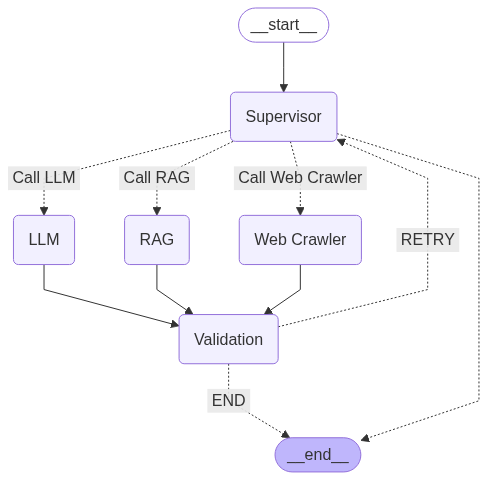

In [64]:
workflow.compile()

In [67]:
# Export Workflow Diagram as PNG/SVG

try:
    # Try to export as PNG
    png_data = app.get_graph().draw_mermaid_png()
    with open("workflow_diagram.png", "wb") as f:
        f.write(png_data)
    print("✅ PNG diagram exported to: workflow_diagram.png")
    
except Exception as e:
    print(f"PNG export failed: {e}")
    
    try:
        # Fallback: Try to export as ASCII and then convert
        from PIL import Image, ImageDraw, ImageFont
        
        ascii_diagram = app.get_graph().draw_ascii()
        
        # Create image from ASCII
        lines = ascii_diagram.split('\n')
        max_width = max(len(line) for line in lines) * 10
        height = len(lines) * 20
        
        img = Image.new('RGB', (max_width, height), color='white')
        draw = ImageDraw.Draw(img)
        
        for i, line in enumerate(lines):
            draw.text((10, i * 20), line, fill='black')
        
        img.save("workflow_diagram.png")
        print("✅ ASCII-based PNG exported to: workflow_diagram.png")
        
    except Exception as e2:
        print(f"ASCII export also failed: {e2}")
        
        # Final fallback: Just save the mermaid text
        mermaid_diagram = app.get_graph().draw_mermaid()
        with open("workflow_diagram.mmd", "w") as f:
            f.write(mermaid_diagram)
        print("✅ Fallback: Mermaid text exported to: workflow_diagram.mmd")
        print("💡 To get PNG: Copy .mmd content to https://mermaid.live/ and export")


✅ PNG diagram exported to: workflow_diagram.png
